In [1]:

# spatial libraries
import shapely.geometry
import pyproj

# package(s) for data handling
import numpy as np
import matplotlib.pyplot as plt
import requests
import plotly.express as px
import pandas as pd
pd.options.display.max_rows = None
import plotly.graph_objects as go

import functools
import itertools
import warnings
warnings.filterwarnings('ignore')
import sys
sys.tracebacklimit=0
# package(s) related to time, space and id
import logging
import datetime, time
import platform

# package(s) related to the simulation
import simpy
import pandas as pd

# spatial libraries 
import pyproj
import shapely.geometry
from simplekml import Kml, Style

# package(s) for data handling

import scipy.optimize
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import tqdm

# Used for mathematical functions
import math             

import plotly.express as px
from plotly.subplots import make_subplots

#logging.basicConfig(level=logging.DEBUG) #turn on all the debug messages
#logging.basicConfig(level=logging.INFO)# turn off all the debug messages

logger = logging.getLogger('notebook')

# Used for making the graph
import networkx as nx

# new OpenTNSim module
import powertrain

In [2]:
# MCR_me_1

In [3]:
# MCR_me_2

In [4]:
# load_factor_me_2

In [5]:
# trip_total_energy = powertrain.calculate_trip_total_energy(power_percentage, MCR_oversize, time_percentage, trip_total_time_hr)
# trip_total_energy

In [6]:
# power_applied = [86,147,208,270,331,392,453,515,576,637,698,760,821,882,943,1005,1066] # exclude stationary
power_applied = [86*0.5,147*0.5,208*0.5,270*0.5,331*0.5,392*0.5,453*0.5,515*0.5,576*0.5,637*0.5,698*0.5,760*0.5,821*0.5,882*0.5,943*0.5,1005*0.5,1066*0.5]
MCR_smallsize_1 = [450,500,550,600] 
MCR_smallsize_2 = [250,300,350,400]                                                                                    


time_percentage = [0.046,0.059,0.074,0.067,0.093,0.117,0.118,0.067,0.058,0.04,0.03,0.027,0.013,0.007,0.004,0.004,0.002] # exclude stationary
MCR_oversize = [1225]

peaktime_percentage = [0.057]
peakpower_load_oversize = [0.77] #ARA_tanker ave

stationarytime_percentage = [0.174]
stationarypower_load_oversize = [0.025] #ARA_tanker ave

trip_total_time_hr = [27] # ARA tanker, AMS-RTD



In [7]:
# prepare the work to be done by creating a list of all combinations
work = list(itertools.product(
        MCR_smallsize_1, 
        MCR_smallsize_2,
        trip_total_time_hr,
        peaktime_percentage,
        stationarytime_percentage,
        MCR_oversize,
        peakpower_load_oversize,
        stationarypower_load_oversize))

# prepare a list of dictionaries for pandas
rows = []
for item in work:
    row = {"MCR_smallsize_1":item[0],"MCR_smallsize_2":item[1], 
           "trip_total_time_hr":item[2],"peaktime_percentage":item[3], "stationarytime_percentage": item[4], 
           "MCR_oversize":item[5], "peakpower_load_oversize": item[6], "stationarypower_load_oversize":item[7]
        }
    rows.append(row)

    # these are all the simulations that we want to run

# convert them to dataframe, so that we can apply a function and monitor progress
work_df = pd.DataFrame(rows)

work_df

,MCR_smallsize_1,MCR_smallsize_2,trip_total_time_hr,peaktime_percentage,stationarytime_percentage,MCR_oversize,peakpower_load_oversize,stationarypower_load_oversize
0,450,250,27,0.057,0.174,1225,0.77,0.025
1,450,300,27,0.057,0.174,1225,0.77,0.025
2,450,350,27,0.057,0.174,1225,0.77,0.025
3,450,400,27,0.057,0.174,1225,0.77,0.025
4,500,250,27,0.057,0.174,1225,0.77,0.025
5,500,300,27,0.057,0.174,1225,0.77,0.025
6,500,350,27,0.057,0.174,1225,0.77,0.025
7,500,400,27,0.057,0.174,1225,0.77,0.025
8,550,250,27,0.057,0.174,1225,0.77,0.025
9,550,300,27,0.057,0.174,1225,0.77,0.025


In [8]:
feasibilities = []

for i, row in tqdm.tqdm(work_df.iterrows(),disable=True):


    (
        battery_capacity_for_trip_kwh, 
        battery_capacity_for_peakpower_kwh,                
        load_factor_tw_ave_ARA_smallsize
    ) = powertrain.calculate_battery_capacity_forARA2smallICE(
        
        peakpower_load_oversize = row['peakpower_load_oversize'],
        stationarypower_load_oversize = row['stationarypower_load_oversize'],
        MCR_oversize = row['MCR_oversize'],                                                                                
        peaktime_percentage = row['peaktime_percentage'], 
        stationarytime_percentage = row['stationarytime_percentage'], 
        trip_total_time_hr = row['trip_total_time_hr'],                                                                                    
        MCR_smallsize_1 = row['MCR_smallsize_1'], 
        MCR_smallsize_2 = row['MCR_smallsize_2'],        
        )    

    
    feasibility ={}
    feasibility.update(row)
    feasibility['battery_capacity_for_trip (kwh)'] = battery_capacity_for_trip_kwh #
    feasibility['battery_capacity_for_peakpower (kwh)'] = battery_capacity_for_peakpower_kwh
    feasibility['load_factor_tw_ave_ARA_smallsize'] = load_factor_tw_ave_ARA_smallsize
    # feasibility['load_factor_tw_ave_ARA_smallsize_2'] = load_factor_tw_ave_ARA_smallsize_2

    
    feasibilities.append(feasibility)

In [9]:
feasibilities = pd.DataFrame(feasibilities)
first_selected = ['load_factor_tw_ave_ARA_smallsize','MCR_smallsize_1','MCR_smallsize_2','battery_capacity_for_trip (kwh)','battery_capacity_for_peakpower (kwh)']
feasibilities = feasibilities[first_selected]
feasibilities = feasibilities[feasibilities['battery_capacity_for_trip (kwh)'] > 0 ] 
feasibilities = feasibilities[feasibilities['battery_capacity_for_peakpower (kwh)'] > 0] 
feasibilities = feasibilities[feasibilities['load_factor_tw_ave_ARA_smallsize'] < 1.01] 
# feasibilities = feasibilities[feasibilities['load_factor_tw_ave_ARA_smallsize_2'] < 1.01] 
feasibilities 

,load_factor_tw_ave_ARA_smallsize,MCR_smallsize_1,MCR_smallsize_2,battery_capacity_for_trip (kwh),battery_capacity_for_peakpower (kwh)
0,0.602578,450.0,250.0,849.791250,535.95675
1,0.591690,450.0,300.0,768.031875,470.54925
2,0.582162,450.0,350.0,686.272500,405.14175
3,0.573755,450.0,400.0,604.513125,339.73425
4,0.552610,500.0,250.0,768.031875,470.54925
5,0.543082,500.0,300.0,686.272500,405.14175
6,0.534675,500.0,350.0,604.513125,339.73425
7,0.527203,500.0,400.0,522.753750,274.32675
8,0.511108,550.0,250.0,686.272500,405.14175
9,0.502701,550.0,300.0,604.513125,339.73425


### ARA tanker right engine sizing scenario of two smaller ICE engines and battery pack

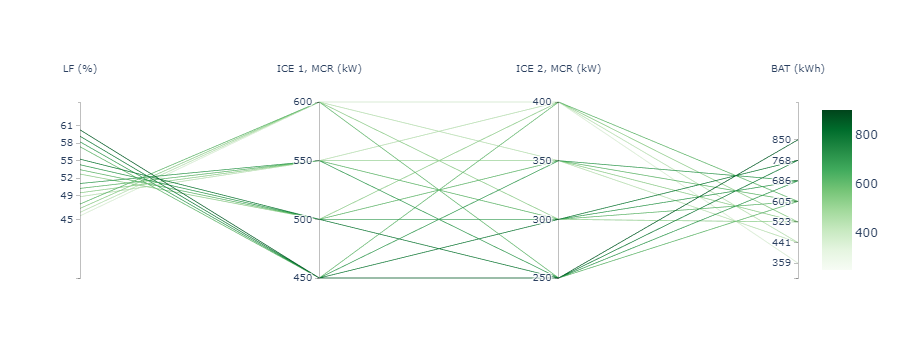

In [14]:

fig = go.Figure(data=
    go.Parcoords(
        line = dict(color = feasibilities ['battery_capacity_for_trip (kwh)'],
                   colorscale = 'greens',
                   showscale = True,
                   cmin = 250,
                   cmax = 900),
        dimensions = list([
            dict(range = [0.35,0.65],
                 # constraintrange = [2,3.5],
                 label = "LF (%)", values = feasibilities['load_factor_tw_ave_ARA_smallsize'],
                 tickvals = [0.65,0.61,0.58,0.55,0.52,0.49,0.45,0.35],
                 ticktext = ['','61', '58','55','52','49','45','']),         
            dict(range = [450,600],
                 # constraintrange = [2,3.5],
                 label = "ICE 1, MCR (kW)", values = feasibilities['MCR_smallsize_1'],
                 tickvals = [450,500,550,600],
                 ticktext = ['450','500', '550','600']), 
            dict(range = [250,400],
                 # constraintrange = [2,3.5],
                 label = "ICE 2, MCR (kW)", values = feasibilities['MCR_smallsize_2'],
                 tickvals = [250,300,350,400],
                 ticktext = ['250','300', '350','400']),
            dict(range = [300,1000],
                 # constraintrange = [2,3.5],
                 label = "BAT (kWh)", values = feasibilities['battery_capacity_for_trip (kwh)'],
                 tickvals = [1000,850,768,686,605,523,441,359,300],
                 ticktext = ['','850', '768','686', '605', '523','441','359','']), 
           
        ]),
        unselected = dict(line = dict(color = 'gainsboro', opacity = 0.5))
    ) 
)

fig.show()

In [15]:
# If you need to save this file as a standalone html file:
fig.write_html("C:/interactiveCharts/right_engine_size_selection_ARAtanker_2_smallICE_battery.html")